In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Ajuster les options d'affichage
pd.set_option('display.max_columns', None)  # Aucune limite sur le nombre de colonnes affichées
pd.set_option('display.max_colwidth', None)  # Aucune limite sur la largeur du contenu de la colonne

In [3]:
# Correctly specifying your file path
path_global_5s_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/train_global_recording_chunks.csv"
path_global_5s_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/test_global_recording_chunks.csv"
path_global_5s_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Global/val_global_recording_chunks.csv"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_global_5s_train)
df_test = pd.read_csv(path_global_5s_test)
df_val = pd.read_csv(path_global_5s_val)

C:\Users\geogeo\AppData\Local\Temp\ipykernel_3632\2723015761.py:7: DtypeWarning: Columns (39,42,44,48,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(path_global_5s_train)


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

def clean_data(df):
    y = df['label']
    y_category = df['label_category']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_encoded = label_encoder.transform(y)

    """df = df.drop(['label', 'recording_chunk_id', 'recording_id', 'annotation_chunk_id', 
                  'sound_type', 'label_category', 'label_kingdom', 'label_class', 
                  'label_order', 'label_family', 'label_subfamily', 'confidence_level', 
                  'vocalization_type', 'code_n_ind', 'annotation_duration_prior_to_split', 
                  'code_unique', 'categorie', 'ordre', 'espece', 'auteur', 'operateur', 
                  'avis_operateur', 'validateur', 'espece_validee', 'permis_utilisation', 
                  'date', 'GPS', 'nb_chanteurs', 'autres_especes_nb', 'autres_especes_annotees', 
                  'bruits_anthropiques', 'bruits_geophoniques', 'bruit_de_fond', 'enregistreur', 
                  'micro', 'bonnette', 'expansion_de_temps', 'localisation', 'annotation', 
                  'annotation_exhaustive', 'photo', 'stereo', 'notes', 'annotation_initial_time', 
                  'annotation_final_time', 'chunk_initial_time', 'chunk_final_time', 'sampling_rate', 
                  'BPS'], axis=1)
    
    df = df.select_dtypes(['number'])"""

    df['duree'] = df['duree_min'] * 60 + df['duree_sec']
    df = df[['min_frequency', 'max_frequency', 'avg_frequency', 'duree']]
    df['min_frequency'] = df['min_frequency'].astype(int)
    df['max_frequency'] = df['max_frequency'].astype(int)

    # Gestion des valeurs manquantes
    #df.fillna(df.mean(), inplace=True)
    df = df.dropna()
    
    # Gestion des variables catégorielles
    df = pd.get_dummies(df)

    X = df

    return X, y_encoded

X_train, y_train = clean_data(df_train)
X_test, y_test = clean_data(df_test)
X_val, y_val = clean_data(df_val)

C:\Users\geogeo\AppData\Local\Temp\ipykernel_3632\3346479836.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_frequency'] = df['min_frequency'].astype(int)
C:\Users\geogeo\AppData\Local\Temp\ipykernel_3632\3346479836.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_frequency'] = df['max_frequency'].astype(int)
C:\Users\geogeo\AppData\Local\Temp\ipykernel_3632\3346479836.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [5]:
X_train

,min_frequency,max_frequency,avg_frequency,duree
0,0,375,187.613067,17
1,3248,4453,602.868652,17
2,3248,4453,602.868652,17
3,0,375,187.613067,17
4,3248,4453,602.868652,17
...,...,...,...,...
17688,3628,15776,6073.780029,185
17689,4750,16160,5704.877197,185
17690,5007,16160,5576.321777,185
17691,4750,16553,5901.409424,185


In [19]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_train])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_train, sample_weight=sample_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
# Évaluation sur l'ensemble de validation
xgb_predictions = xgb_model.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Évaluation LightGBM
print("Évaluation LightGBM :")
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))

Évaluation LightGBM :
Accuracy sur l'ensemble de validation: 0.6500655307994757
              precision    recall  f1-score   support

           0       0.15      0.17      0.16        24
           1       0.60      0.50      0.55         6
           2       0.88      1.00      0.93        14
           3       0.33      0.33      0.33         6
           4       0.00      0.00      0.00        12
           5       0.95      0.90      0.92        20
           6       0.86      0.63      0.73        38
           7       1.00      0.75      0.86         8
           8       0.61      1.00      0.76        11
           9       0.42      0.50      0.46        16
          10       0.75      0.33      0.46         9
          11       1.00      1.00      1.00         7
          12       0.94      0.94      0.94        18
          13       1.00      1.00      1.00         6
          14       0.61      0.71      0.65        24
          15       0.40      0.40      0.40         5
 

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, xgb_predictions)
y_test_inversed = label_encoder.inverse_transform(y_test)

In [23]:
unique_labels = np.unique(y_test_inversed)

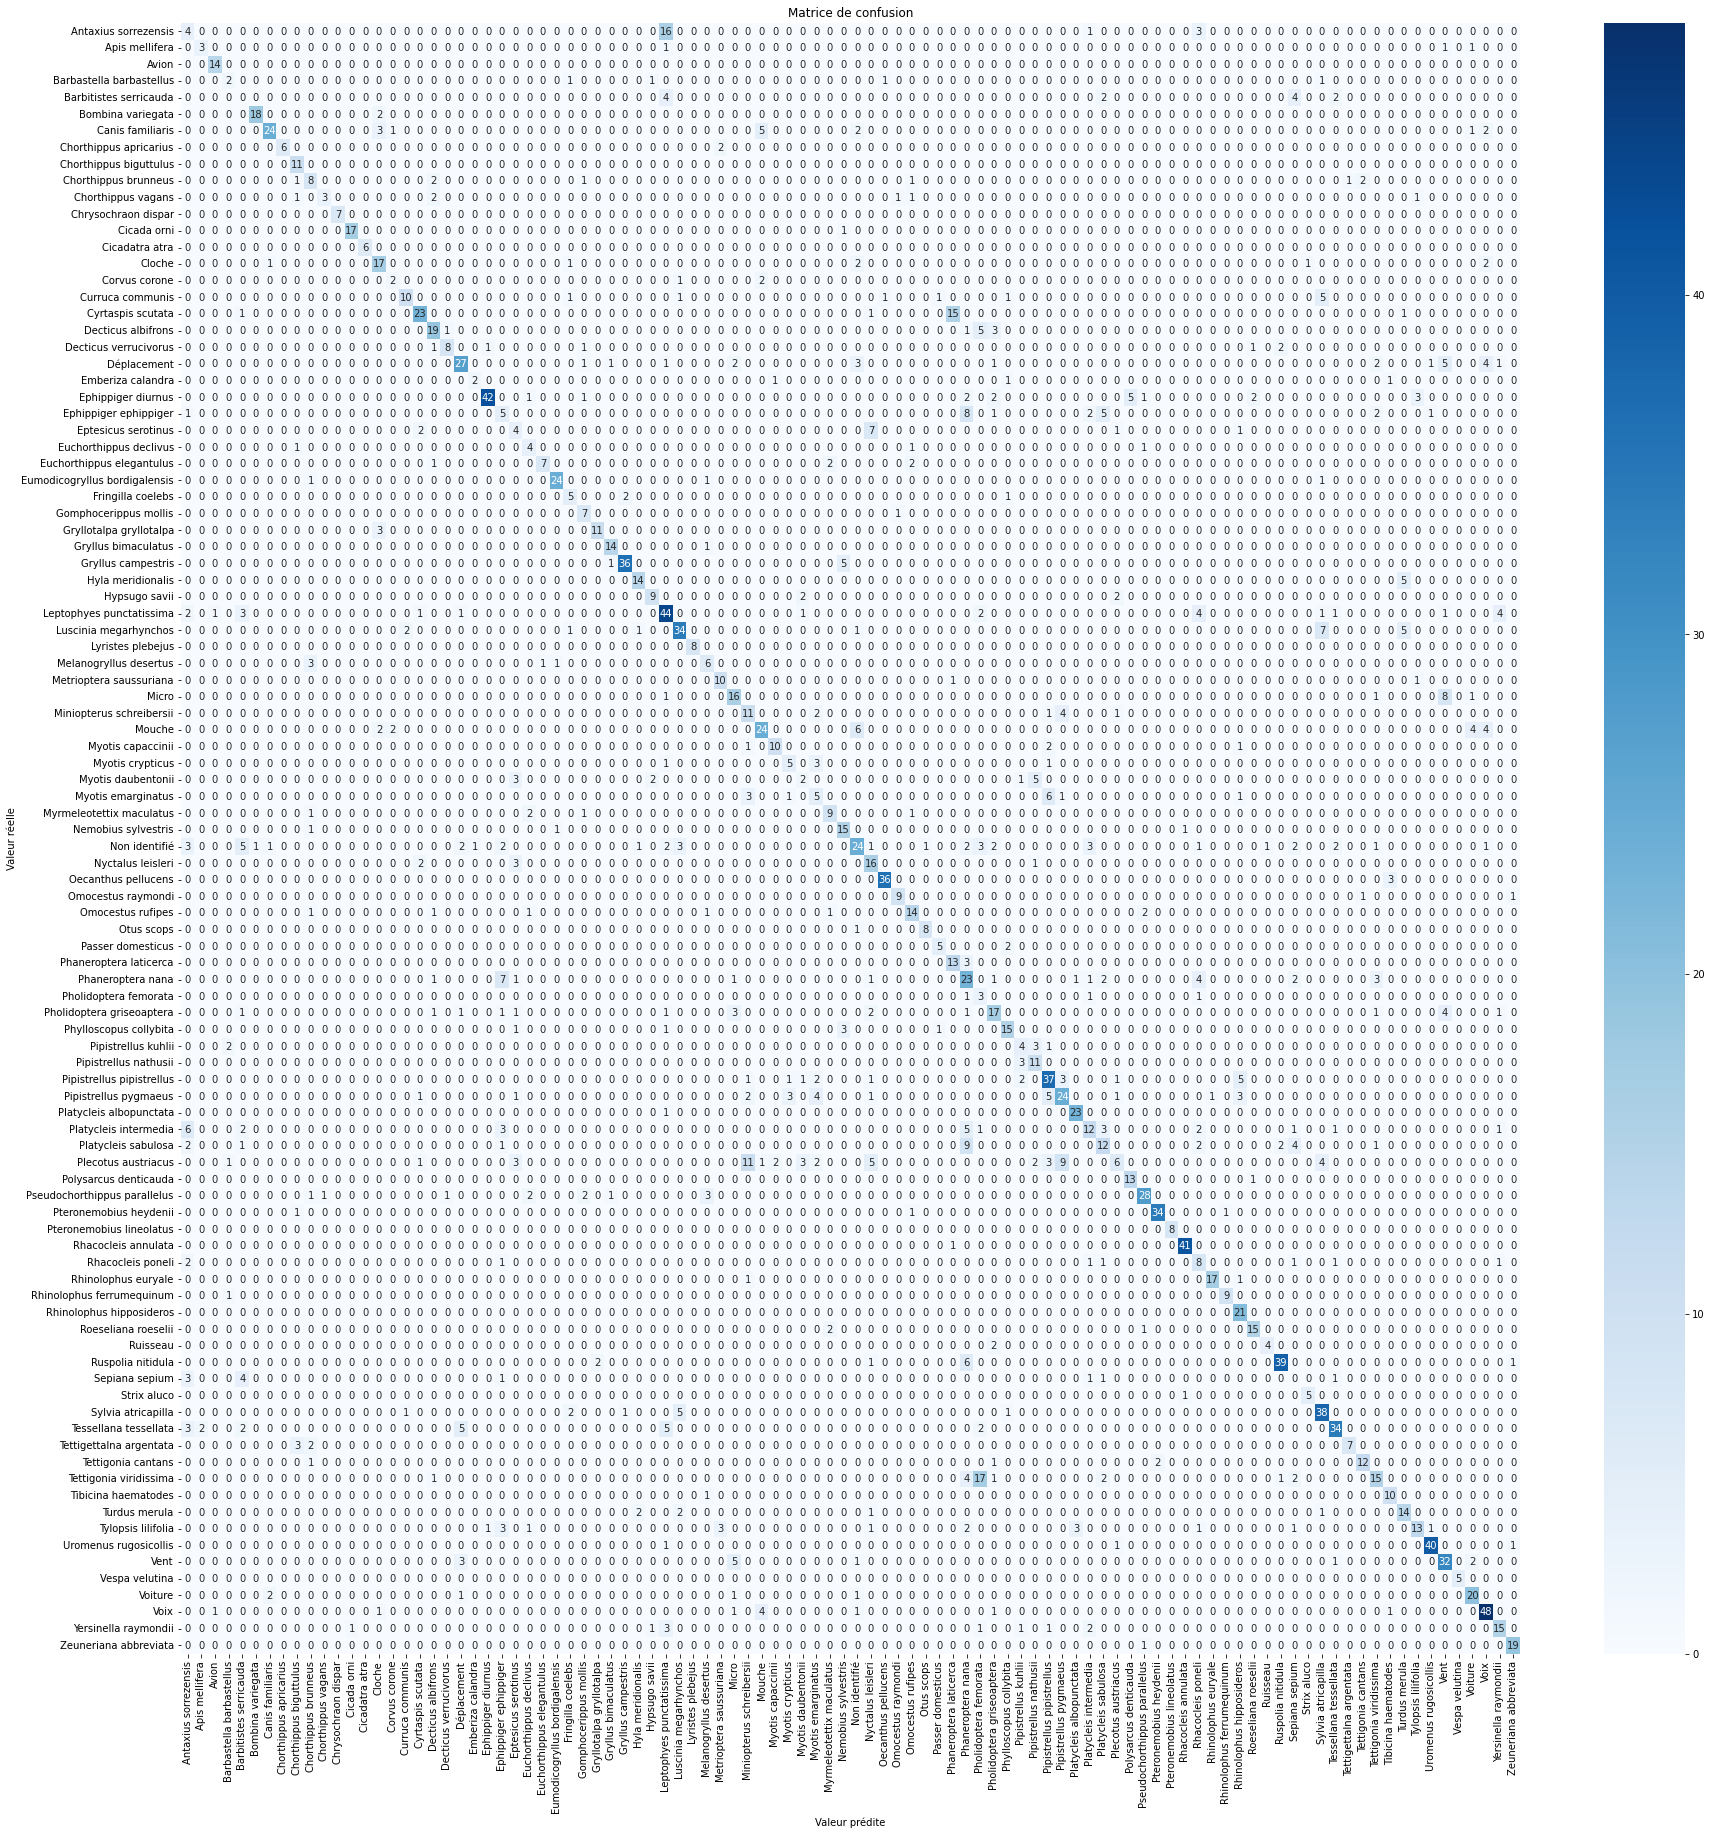

In [24]:
plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Matrice de confusion')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()